# **Variational AutoEncoder (VAE) for CIFARA-100 Dataset**

**Install Libraries**

In [7]:
!pip install cloudpickle

**Import Libraries**

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cloudpickle as cPickle

import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar100
import tensorflow as tf

**Define Hyperparameters**

In [3]:
img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 3
intermediate_dim = 128
epsilon_std = 1.0
epochs = 200
filters = 32
num_conv = 3
batch_size = 128

**Select Channels**

In [4]:
# tensorflow uses channels_last
# theano uses channels_first
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

**Define Encoder Architecture**

In [5]:
# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

**Define Mean and Variance**

In [6]:
# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

**Define Sampling Function**

In [9]:
# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

**Define Decoder Architecture**

In [10]:
# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * int(img_rows / 2) * int(img_cols / 2), activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
else:
    output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

**Define Custom Variational Layer**

In [11]:
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])

**Define Loss Function**

In [12]:
def vae_loss(x, x_decoded_mean_squash):
    x = K.flatten(x)
    x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
    kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

# Modify the model to output both the reconstructed image and the input image
vae = Model(x, [x_decoded_mean_squash, x])

# Update the model compilation to use the custom VAE loss
vae.add_loss(vae_loss(x, x_decoded_mean_squash))
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 3)            39        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 32)           416       ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 16, 16, 32)           9248      ['conv2d_1[0][0]']            
                                                                                              

**Load CIFAR-100 Dataset**

In [13]:
# load dataset
(x_train, _), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
y_test = y_test.astype('float32') / 255.
y_test = y_test.reshape((y_test.shape[0],))

169001437/169001437 [==============================] - 2s 0us/step


**Train VAE**

In [14]:
# training
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test))

Epoch 1/200
391/391 [==============================] - 13s 10ms/step - loss: 651.0268 - val_loss: 635.6848
Epoch 2/200
391/391 [==============================] - 3s 8ms/step - loss: 632.4940 - val_loss: 634.1780
Epoch 3/200
391/391 [==============================] - 3s 8ms/step - loss: 630.1150 - val_loss: 628.3485
Epoch 4/200
391/391 [==============================] - 3s 9ms/step - loss: 628.4141 - val_loss: 628.1797
Epoch 5/200
391/391 [==============================] - 3s 8ms/step - loss: 626.8630 - val_loss: 627.3561
Epoch 6/200
391/391 [==============================] - 3s 9ms/step - loss: 625.7877 - val_loss: 627.0188
Epoch 7/200
391/391 [==============================] - 4s 9ms/step - loss: 625.1141 - val_loss: 627.7019
Epoch 8/200
391/391 [==============================] - 3s 8ms/step - loss: 624.5078 - val_loss: 627.0782
Epoch 9/200
391/391 [==============================] - 3s 8ms/step - loss: 624.0088 - val_loss: 626.4069
Epoch 10/200
391/391 [==============================]

**Define Encoder Model**

In [15]:
# encoder from learned model
encoder = Model(x, z_mean)

**Define Decoder Model**

In [16]:
# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

**Save Models**

In [18]:
# save all 3 models for future use - especially generator
vae.save('../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
generator.save('../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs))

**Save Training History**

In [19]:
# save training history
fname = '../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
with open(fname, 'wb') as file_pi:
    cPickle.dump(history.history, file_pi)

**Load Saved Models**

In [20]:
# load saved models
vae = keras.models.load_model('../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
encoder = keras.models.load_model('../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
generator = keras.models.load_model('../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})


**Load Training History**

In [21]:
# load history if saved
fname = '../models/cifar100_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
try:
    with open(fname, 'rb') as fo:
        history = cPickle.load(fo)
    print(history)
except:
    print("training history not saved")

{'loss': [651.0267944335938, 632.4940185546875, 630.114990234375, 628.4141235351562, 626.863037109375, 625.7876586914062, 625.1141357421875, 624.5078125, 624.0087890625, 623.6427612304688, 623.3478393554688, 623.0703735351562, 622.7996215820312, 622.5776977539062, 622.3849487304688, 622.2167358398438, 621.96533203125, 621.8469848632812, 621.6652221679688, 621.5653076171875, 621.3418579101562, 621.2504272460938, 621.1366577148438, 620.9802856445312, 620.880126953125, 620.7660522460938, 620.6410522460938, 620.5526733398438, 620.445068359375, 620.312255859375, 620.1898803710938, 620.1063232421875, 620.0222778320312, 619.9131469726562, 619.7823486328125, 619.6583862304688, 619.5987548828125, 619.4526977539062, 619.3716430664062, 619.3021240234375, 619.2610473632812, 619.0668334960938, 619.0015258789062, 618.9212036132812, 618.85693359375, 618.7706909179688, 618.6537475585938, 618.63671875, 618.5653076171875, 618.4705200195312, 618.3741455078125, 618.3263549804688, 618.2676391601562, 618.16

**Display Latent Space**

79/79 [==============================] - 0s 4ms/step


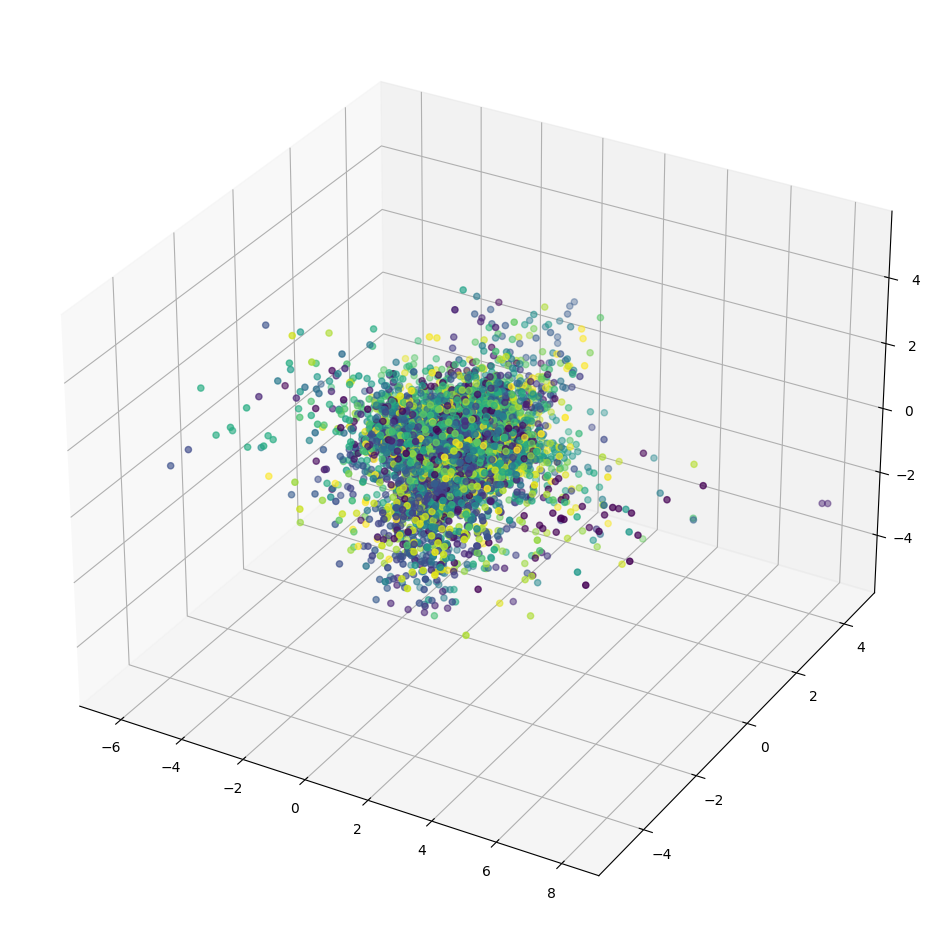

In [22]:
if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

In [23]:
if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

**Display Random Generated Images**

1/1 [==============================] - 0s 16ms/step


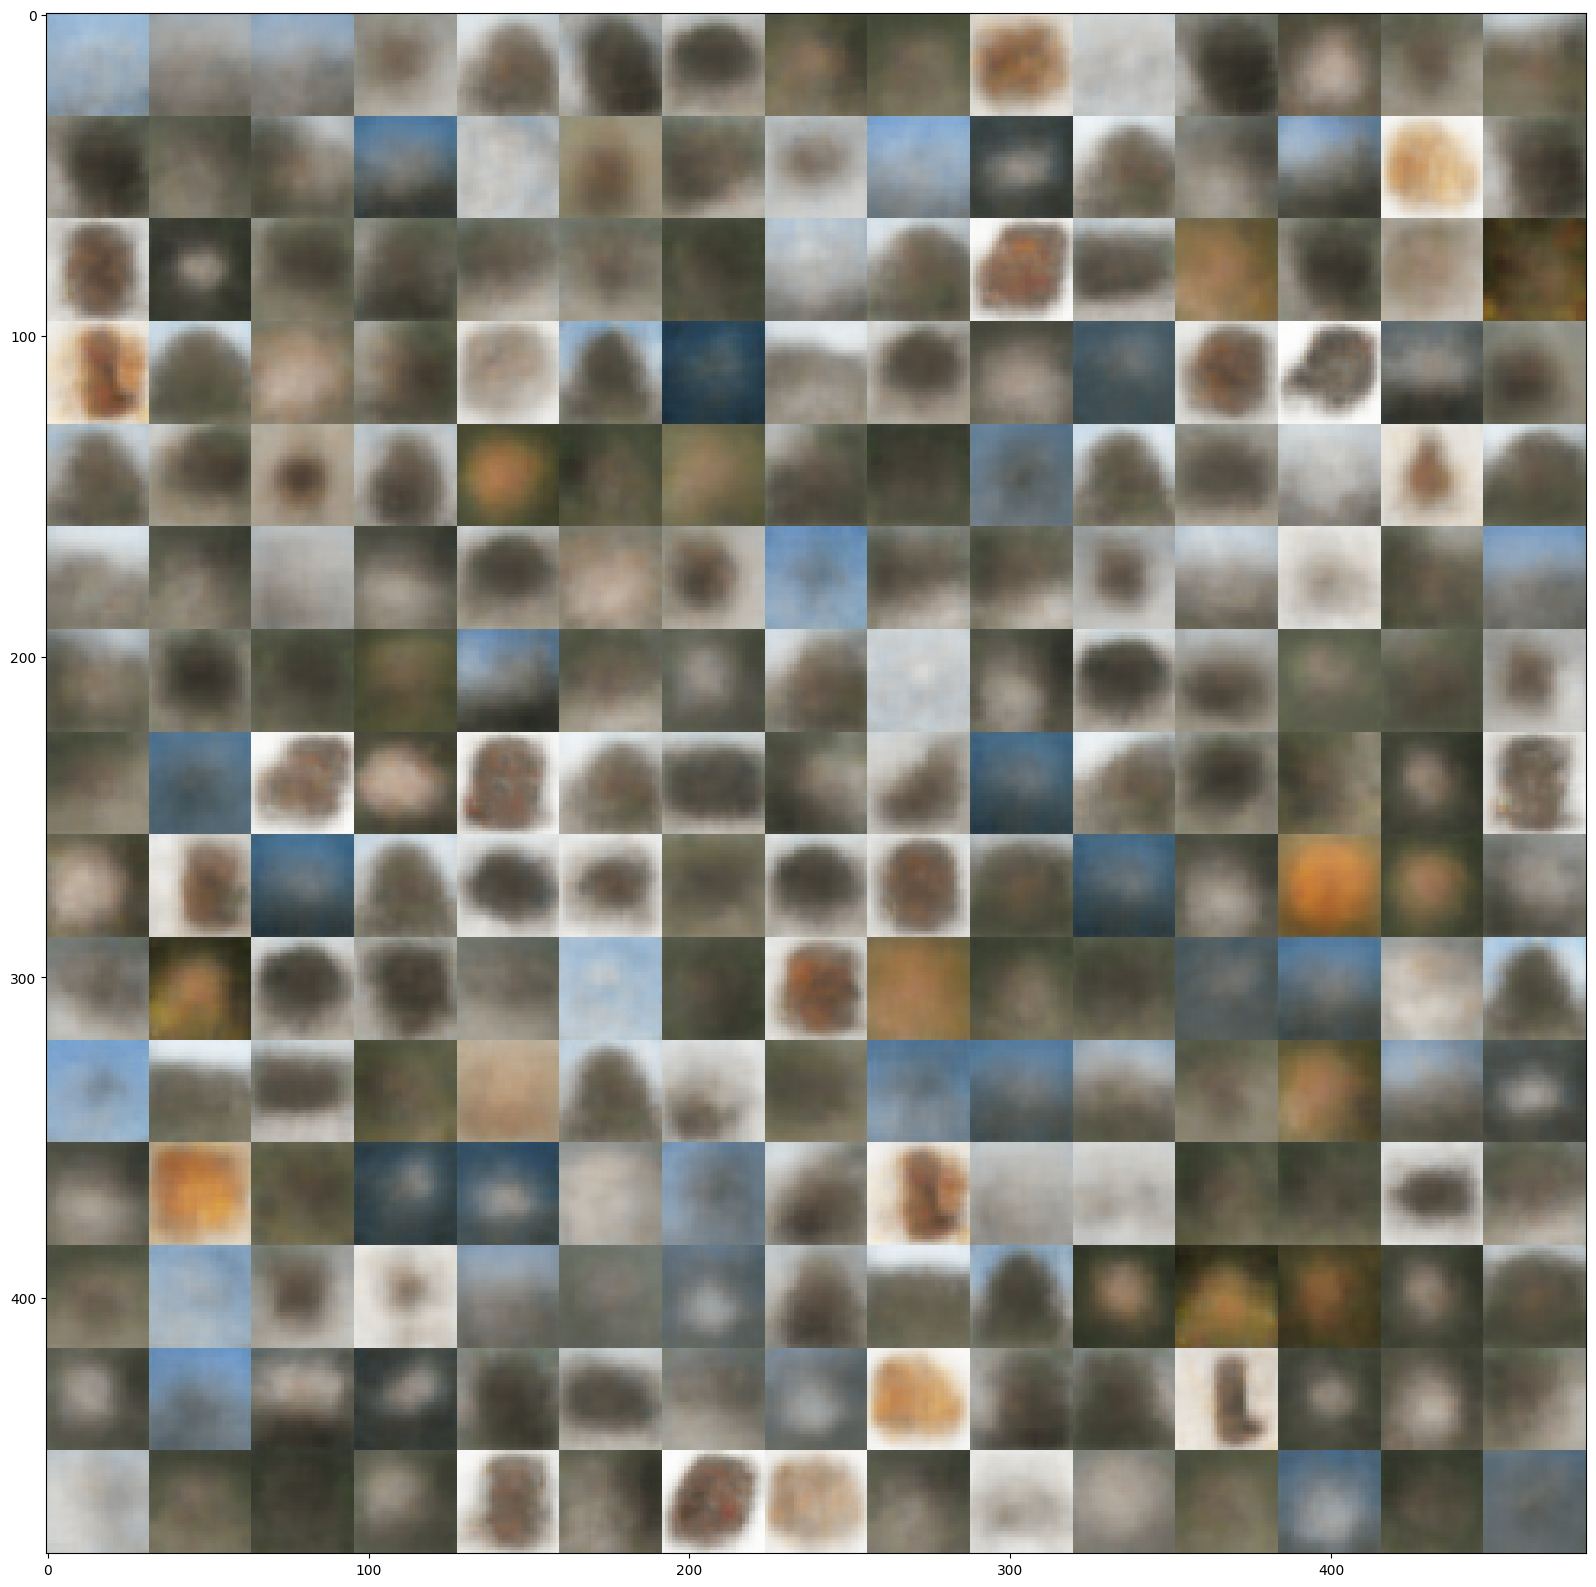

In [24]:
# display images generated from randomly sampled latent vector
n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img



plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap=None)
plt.show()

**Display Sampled Images**

1/1 [==============================] - 0s 17ms/step


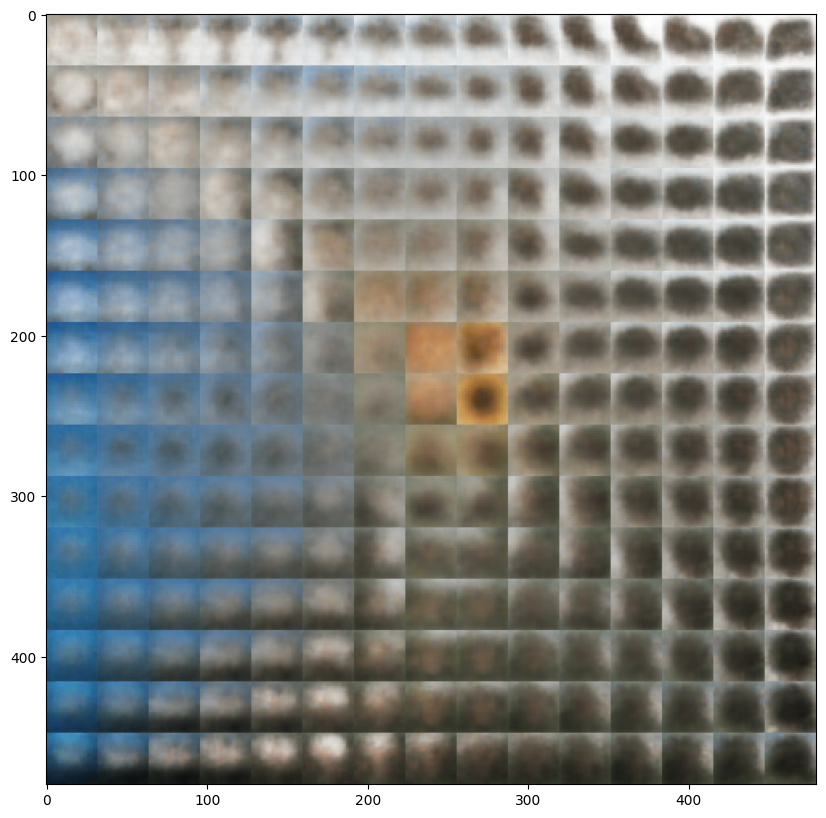

In [25]:
# display a 2D manifold of the images
n = 15  # figure with 15x15 images
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi, 0]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 3)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap=None)
plt.show()